# INSTACART Market Basket Analysis

Which products will an Instacart consumer purchase again? Data for this project is downloaded from:
https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis

## DATA DESCRIPTION

The dataset contains:

    Over 3 million grocery orders

    Data from more than 200,000 Instacart users

    Each user has between 4 and 100 orders available

    The sequence of products purchased in each order

    Information about the day of the week and time of day when the order was placed

    A relative measure of the time between orders

THE CHALLENGE
A similar exercise was carried out 7 years ago and achieved an accuracy of approximately 76% using a Random Forest model. You can read its description here, as well as the authors' solution: 
https://gist.github.com/olgabradford/f04f23692c78fc0beb377894ce5e5e59

The challenge is to surpass this performance! How?

    By implementing an AI-powered solution based on the original algorithm or a similar one

    By testing alternative and more modern algorithms — such as deep learning or gradient boosting (XGBoost, LightGBM)

    By implementing neural network–based approaches (RNNs, transformers)

    By creating a stacked model (ensemble of models)

    By applying innovative feature engineering techniques

    By adding external or synthetic data

    By analyzing temporal patterns in buying behavior

    By applying embedding techniques for products or customers

## DATA ANALYSIS

New tables were created based on related features.Following the visual data analysis features were chosen for machine learning algorithms.Feature selections was perfomed using SelectKBest.Top 15 features were selected as the best features  for predition of the product in the next curstomer's order.The machine learning algorithm used for classification is XGBoost.Was also implemented a stacked model(Multilayer Perceptron) for obtaining the best accuracy.


#### 1) IMPORTING THE NECCESARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
import xgboost as xgb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns

#### 2) EXTRACTING THE DATASET

In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

#### 3) FEATURE ENGINEERING

##### User features:
 Describe the user's overall shopping behavior (e.g., how many orders, reorder rate, average days between orders).

##### Product features:
 Describe each product’s popularity and reorder tendency (e.g., how many times it was ordered, how often it’s reordered).

##### User-product interaction features:
 Describe the relationship between a specific user and a specific product (e.g., how many times the user ordered this product, average position in cart, how often the user reorders it).

##### Time features:
 Capture the user’s most common shopping day and hour.


These features help the model learn patterns about users's behaviour and their next likely order, improving prediction accuracy.

In [3]:
def create_features(df):
    """Feature engineering with leak-proof calculations"""
    # User features
    user_features = df.groupby('user_id').agg({
        'order_id': 'nunique',
        'reordered': 'mean',
        'days_since_prior_order': 'mean'
    }).rename(columns={
        'order_id': 'user_total_orders',
        'reordered': 'user_reorder_rate',
        'days_since_prior_order': 'user_mean_days'
    })
    
    # Product features
    product_features = df.groupby('product_id').agg({
        'order_id': 'nunique',
        'reordered': 'mean'
    }).rename(columns={
        'order_id': 'product_order_count',
        'reordered': 'product_reorder_rate'
    })
    
    # User-product interaction features
    user_product_features = df.groupby(['user_id', 'product_id']).agg({
        'order_id': 'nunique',
        'add_to_cart_order': 'mean',
        'days_since_prior_order': 'mean',
        'reordered': ['sum', 'mean']
    })
    user_product_features.columns = [
        'up_orders', 'up_avg_cart_pos', 
        'up_avg_days_between', 'up_reorder_sum', 'up_reorder_rate'
    ]
    
    # Time features
    time_features = df.groupby('user_id').agg({
        'order_dow': lambda x: x.mode()[0],
        'order_hour_of_day': lambda x: x.mode()[0] 
    }).rename(columns={
        'order_dow': 'user_peak_day',
        'order_hour_of_day': 'user_peak_hour'
    })
    
    return user_features, product_features, user_product_features, time_features

#### 4) MERGING DATA BASED ON SIMILARITIES

In [4]:
products = products.merge(aisles, on='aisle_id').merge(departments, on='department_id')

# Prepare training data
train_orders = orders[orders['eval_set'] == 'train']
train_data = train_orders.merge(order_products_train, on='order_id', how='left')
train_data['reordered'] = train_data['reordered'].fillna(0)

# Prepare prior data for feature creation
prior_data = orders[orders['eval_set'] == 'prior'].merge(order_products_prior, on='order_id').merge(products, on='product_id')
prior_data['days_since_prior_order'] = prior_data['days_since_prior_order'].fillna(prior_data['days_since_prior_order'].mean())

# Create features
user_features, product_features, user_product_features, time_features = create_features(prior_data)

# Merge features with training data
train_data = train_data.merge(user_features, on='user_id', how='left')\
                      .merge(product_features, on='product_id', how='left')\
                      .merge(user_product_features, on=['user_id', 'product_id'], how='left')\
                      .merge(time_features, on='user_id', how='left')
                      
# Select numeric features and target
X = train_data.select_dtypes(include=['number']).drop(['reordered', 'eval_set'], axis=1, errors='ignore')
y = train_data['reordered']

# Replace NaN values with column means
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### DATA VISUALIZATION

Visalizing the first 5 observations of the products dataset

In [5]:
print(products.head())

   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id                       aisle department  
0             19               cookies cakes     snacks  
1             13           spices seasonings     pantry  
2              7                         tea  beverages  
3              1                frozen meals     frozen  
4             13  marinades meat preparation     pantry  


Visualizing the first 5 observations of the train dataset

In [6]:
print(train_data.head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   1187899        1    train            11          4                  8   
1   1187899        1    train            11          4                  8   
2   1187899        1    train            11          4                  8   
3   1187899        1    train            11          4                  8   
4   1187899        1    train            11          4                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  ...  \
0                    14.0         196                  1          1  ...   
1                    14.0       25133                  2          1  ...   
2                    14.0       38928                  3          1  ...   
3                    14.0       26405                  4          1  ...   
4                    14.0       39657                  5          1  ...   

   user_mean_days  product_order_count  product_reorder_rate  up_orders  \
0    

Visualizing the first 5 observations of the prior dataset

In [7]:
print(prior_data.head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0               11.104074         196                  1          0   
1               11.104074       14084                  2          0   
2               11.104074       12427                  3          0   
3               11.104074       26088                  4          0   
4               11.104074       26405                  5          0   

                              product_name  aisle_id  department_id  \
0                                     S

Compared the reorder rate of the train and prior datasets to come up with the busiest day of the week

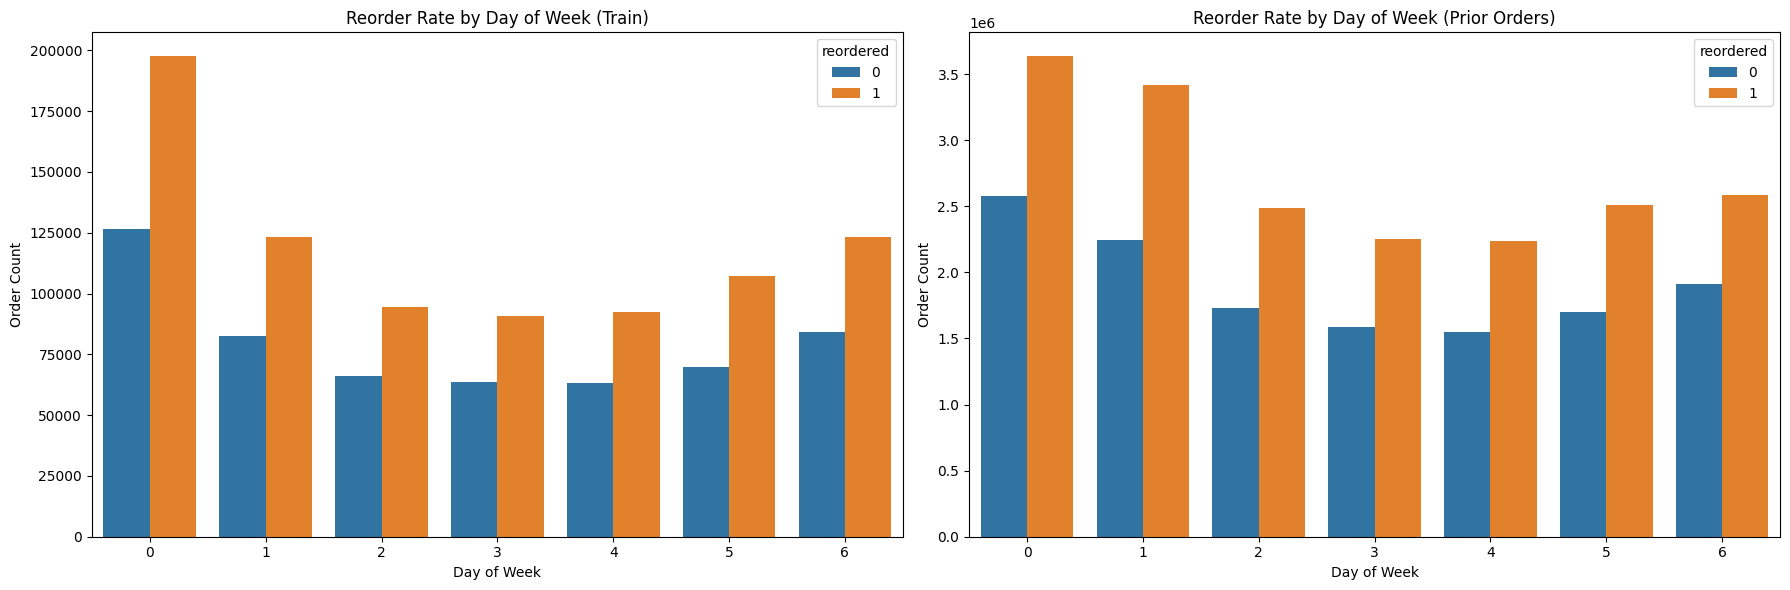

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(data=train_data, x='order_dow', hue='reordered', ax=axes[0])
axes[0].set_title('Reorder Rate by Day of Week (Train)')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Order Count')

sns.countplot(data=prior_data, x='order_dow', hue='reordered', ax=axes[1])
axes[1].set_title('Reorder Rate by Day of Week (Prior Orders)')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Order Count')

plt.tight_layout()
plt.show()

Compared the reorder rate of the prior and train datasets to come up with the busiest hour of the day

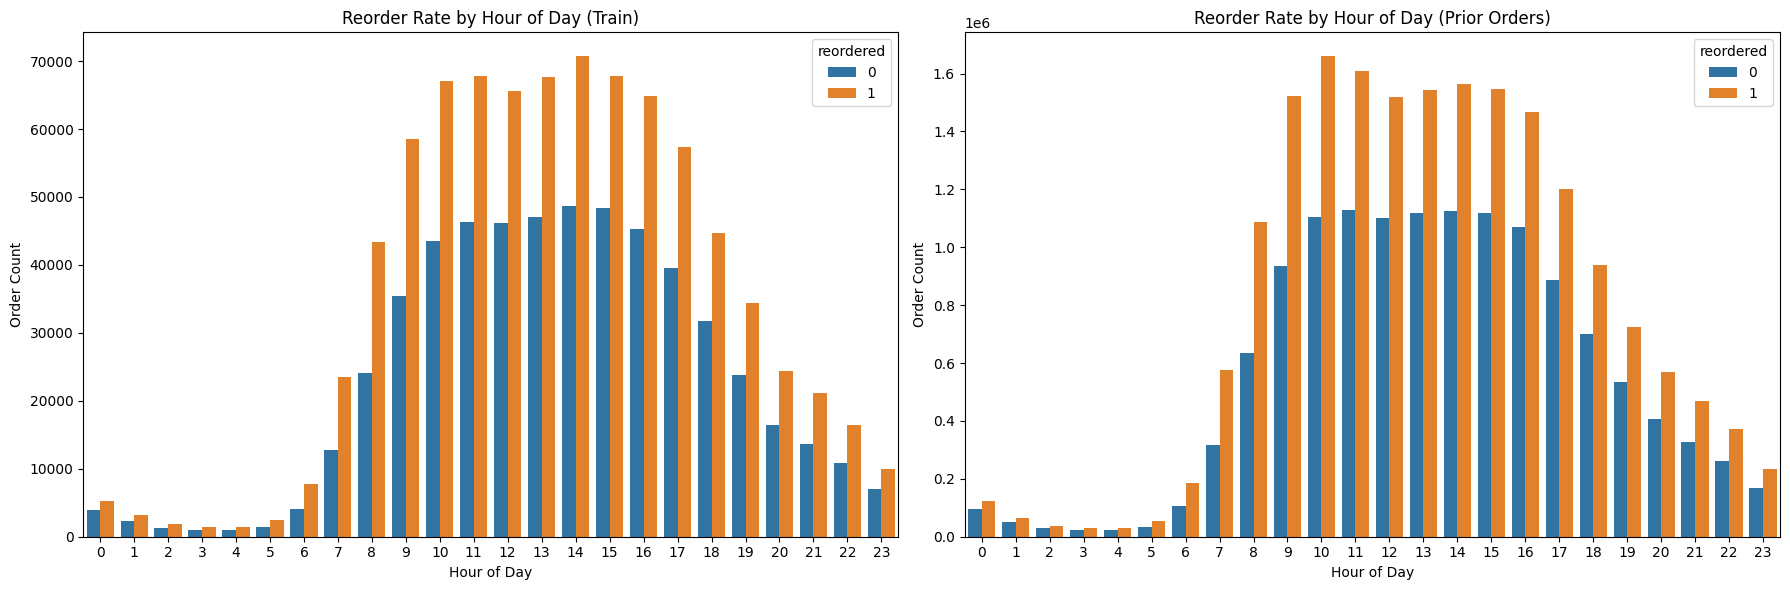

In [9]:
fig, ax = plt.subplots(1,2,figsize=(18, 6))

sns.countplot(data=train_data, x='order_hour_of_day', hue='reordered', ax=ax[0])
ax[0].set_title('Reorder Rate by Hour of Day (Train)')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Order Count')

sns.countplot(data=prior_data, x='order_hour_of_day', hue='reordered', ax=ax[1])
ax[1].set_title('Reorder Rate by Hour of Day (Prior Orders)')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Order Count')
plt.tight_layout()
plt.show()

Compared the two datasets to come up with the most popular product based on its product id(Top 20 only)

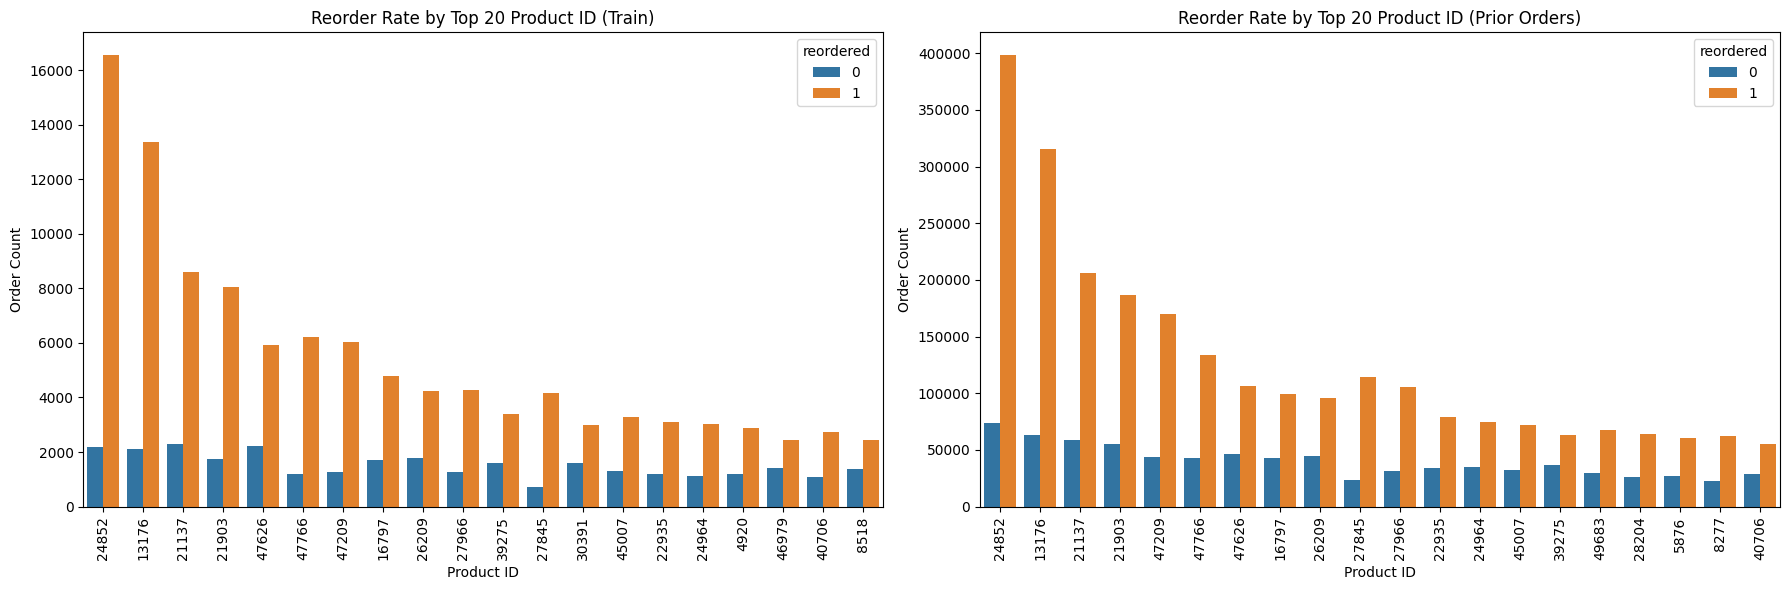

In [10]:
top20_train = train_data['product_id'].value_counts().head(20).index
top20_prior = prior_data['product_id'].value_counts().head(20).index

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(
    data=train_data[train_data['product_id'].isin(top20_train)],
    x='product_id', hue='reordered', ax=ax[0],
    order=top20_train
)
ax[0].set_title('Reorder Rate by Top 20 Product ID (Train)')
ax[0].set_xlabel('Product ID')
ax[0].set_ylabel('Order Count')

sns.countplot(
    data=prior_data[prior_data['product_id'].isin(top20_prior)],
    x='product_id', hue='reordered', ax=ax[1],
    order=top20_prior
)
ax[1].set_title('Reorder Rate by Top 20 Product ID (Prior Orders)')
ax[1].set_xlabel('Product ID')
ax[1].set_ylabel('Order Count')

ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Displayed the most popular products for the prior orders (Top 20 only)

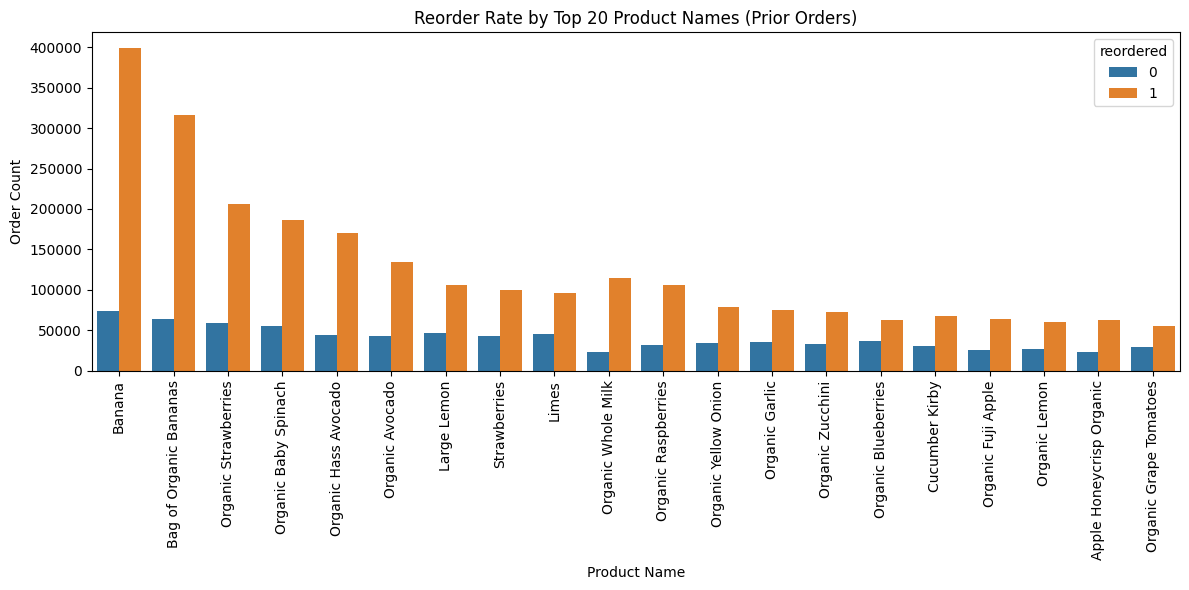

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=prior_data, x='product_name', hue='reordered', order=prior_data['product_name'].value_counts().head(20).index)
plt.title('Reorder Rate by Top 20 Product Names (Prior Orders)')
plt.xlabel('Product Name')
plt.ylabel('Order Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### 5) SELECTING TOP FEATURES

Chose the top 15 features based on importance using the SelectKBest classifier

In [12]:
# Feature selection
skb = SelectKBest(f_classif, k='all').fit(X_imputed, y)
scores = skb.scores_
features = X_imputed.columns.values

# Rank features by importance
feature_ranking = pd.DataFrame({
    'feature': features,
    'score': scores
}).sort_values('score', ascending=False)

print("Top 20 Features by ANOVA F-value:")
print(feature_ranking.head(20))

# Select top features (e.g., top 15)
top_features = feature_ranking['feature'].head(15).values
X_selected = X_imputed[top_features]

Top 20 Features by ANOVA F-value:
                   feature         score
9        user_reorder_rate  1.837886e+05
12    product_reorder_rate  1.409333e+05
2             order_number  7.310819e+04
8        user_total_orders  7.310819e+04
5   days_since_prior_order  3.644819e+04
10          user_mean_days  3.491990e+04
11     product_order_count  3.302314e+04
7        add_to_cart_order  3.032361e+04
19          user_peak_hour  5.461388e+02
4        order_hour_of_day  4.408304e+02
18           user_peak_day  4.008797e+02
3                order_dow  6.242606e+01
6               product_id  5.957891e+01
1                  user_id  2.579245e+01
0                 order_id  2.784817e+00
14         up_avg_cart_pos  6.502487e-10
16          up_reorder_sum  1.373538e-10
13               up_orders  0.000000e+00
17         up_reorder_rate  0.000000e+00
15     up_avg_days_between -1.626060e-09


#### 6) SELECTING THE TRAIN AND TEST DATA

Used to obtain higher metrics 

In [13]:
# Time-based train-test split
train_idx = train_data[train_data['order_number'] < train_data['order_number'].quantile(0.8)].index
test_idx = train_data[train_data['order_number'] >= train_data['order_number'].quantile(0.8)].index

X_train, X_test = X_selected.loc[train_idx], X_selected.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

For order prediction or any time-dependent data, time-based split is preferred to avoid data leakage and to better simulate real-world prediction tasks.
Use train_test_split() only if data points are independent and not sequential.

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X_selected, y, test_size=0.2, random_state=42, stratify=y
# )

Using this method results in lower metrics:

Model Performance:

Accuracy: 0.7049

F1 Score: 0.7382

Recall: 0.6950

Precision: 0.7870

## XGBoost

#### 7) DEFINING THE MODEL'S PARAMENTERS

The model chose for this experiment is XGBoost

    n_estimators = number of decision trees

    max_depth = maximum depth of each tree
    
    subsample = fraction of train data for each tree
    
    colsample_bytree = fraction of features

    gamma = minimum loss reduction required to make a further partition on a leaf node

    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]) = balances  positive and negative classes

    !!!!!! early_stopping_rounds = prevents the model to not overfit


In [15]:
model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    eval_metric='logloss',
    early_stopping_rounds=20,
    tree_method='hist'
)

#### 8) TRAINING THE XGBoost MODEL

verbose = the model will print a progression message every 10 iterations

In [16]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10
)

[0]	validation_0-logloss:0.68491	validation_1-logloss:0.67846
[10]	validation_0-logloss:0.63664	validation_1-logloss:0.58299
[20]	validation_0-logloss:0.61160	validation_1-logloss:0.52653
[30]	validation_0-logloss:0.59958	validation_1-logloss:0.49999
[40]	validation_0-logloss:0.59292	validation_1-logloss:0.48469
[50]	validation_0-logloss:0.58874	validation_1-logloss:0.47393
[60]	validation_0-logloss:0.58615	validation_1-logloss:0.46752
[70]	validation_0-logloss:0.58437	validation_1-logloss:0.46303
[80]	validation_0-logloss:0.58319	validation_1-logloss:0.45905
[90]	validation_0-logloss:0.58226	validation_1-logloss:0.45655
[100]	validation_0-logloss:0.58150	validation_1-logloss:0.45470
[110]	validation_0-logloss:0.58091	validation_1-logloss:0.45358
[120]	validation_0-logloss:0.58046	validation_1-logloss:0.45265
[130]	validation_0-logloss:0.58003	validation_1-logloss:0.45205
[140]	validation_0-logloss:0.57971	validation_1-logloss:0.45168
[150]	validation_0-logloss:0.57938	validation_1-log

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

#### 9) FEATURE IMPORTANCE

Visual represenation of the first 15 most important features

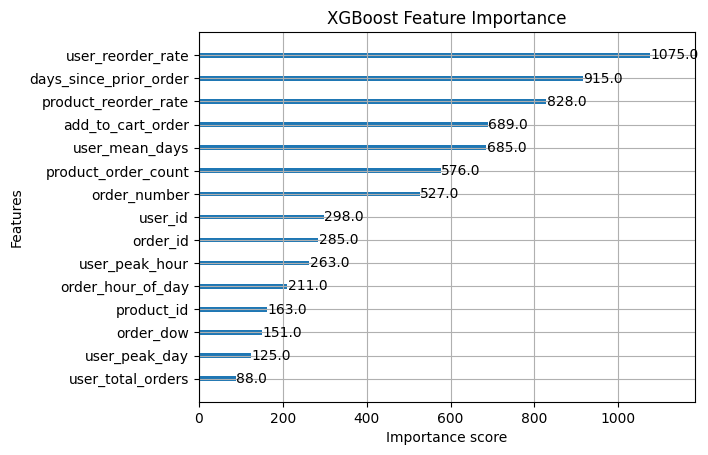

In [17]:
xgb.plot_importance(model, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.show()

#### 10) EVALUATE THE MODEL

In [18]:
y_pred = model.predict(X_test)

#### 11) EVALUATE MODEL PERFORMANCE

In [19]:
print(f"\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")


Model Performance:
Accuracy: 0.7981
F1 Score: 0.8803
Recall: 0.9475
Precision: 0.8220


## MLP(Multilayer Perceptron)

#### 12) DEFINING THE STACKED MODEL

The model has 2 hidden layers with a RELU activation function and the output layer has a sigmoid activation layer.

In [20]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

#### 13) CONVERTING DATA INTO PYTORCH TENSORS

device = selects the fastest available computation method gpu/cpu

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

#### 14) TRAINING LOOP

optimizer = clear the previous gradients

In [22]:

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        

Epoch [10/50], Loss: 45.1641
Epoch [20/50], Loss: 45.0324
Epoch [30/50], Loss: 45.0296
Epoch [40/50], Loss: 45.0299
Epoch [50/50], Loss: 45.0299


#### 15) EVALUATE THE MODEL

Note- the perfect recall score of 1.0000 is highly suspicious. Our model utilize all the true positives in our dataset which is highly unusual in a real life scenario. Also the MLP is a model which is predicted to overfitting.

In [23]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor)
    y_pred = (y_pred_prob > 0.5).float()
    accuracy = accuracy_score(y_test_tensor.cpu(), y_pred.cpu())
    f1 = f1_score(y_test_tensor.cpu(), y_pred.cpu())
    recall = recall_score(y_test_tensor.cpu(), y_pred.cpu())
    precision = precision_score(y_test_tensor.cpu(), y_pred.cpu())
    print(f'\nModel Performance:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')


Model Performance:
Accuracy: 0.7835
F1 Score: 0.8786
Recall: 1.0000
Precision: 0.7835
